## Comparison of the influence of different meshes on wall shear stress and residuals 

#### The simulation was run with six meshes of different refinement levels. They will be refered to as 1 to 6. 1 being the least and 6 the most refined.


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# number of tested meshes 
num_meshes = 6

# file path
path = '../test_cases/RANS_kOmega-SST_2D/'

# number of iterations at which the wall shear stress is analyzed
num_iterations = 4000

# density of the airflow 
rhoL = 1.225

### Direct comparison of the residuals of each field variable

In [111]:
# column names 
colnames = [
    "Time", "U_solver", "Ux_initial", "Ux_final", "Ux_iters",
    "Uy_initial", "Uy_final", "Uy_iters", "U_converged",
    "k_solver", "k_initial", "k_final", "k_iters", "k_converged",
    "omega_solver", "omega_initial", "omega_final", "omega_iters", "omega_converged",
    "p_solver", "p_initial", "p_final", "p_iters", "p_converged"
]

def pltAllResiduals():
# plotting 
    plt.figure(figsize=(10, 6 * num_meshes))

    # for all meshes 
    for i in range(1, num_meshes + 1):
        # Pfad zur Datei
        filepath = f"{path}/output/MeshConvergence/mesh_{i}/postProcessing/solverInfo/0/solverInfo.dat"
        
        # reading data
        df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)
        
        # subplots
        plt.subplot(num_meshes, 1, i)
        plt.plot(df["Time"], df["Ux_initial"], label="Ux_initial")
        plt.plot(df["Time"], df["Uy_initial"], label="Uy_initial")
        plt.plot(df["Time"], df["k_initial"], label="k_initial")
        plt.plot(df["Time"], df["p_initial"], label="p_initial")
        plt.plot(df["Time"], df["omega_initial"], label="omega_initial")
        
        plt.xlabel("Iteration")
        plt.ylabel("Initial residuals (log)")
        plt.title(f"Initial residuals Mesh {i}")
        plt.yscale('log')
        plt.grid(True, which="both", linestyle="--", linewidth=0.5)
        plt.legend()

    # showing layout
    plt.tight_layout()
    plt.show()

### Comparison of the residuals of each mesh

In [112]:
def CompResiduals():
    # colors for each mesh 
    colors = ['blue', 'green', 'red', 'orange', 'purple','pink']

    # reading data
    dfs = []
    for i in range(1, num_meshes + 1):
        filepath = f"{path}/output/MeshConvergence/mesh_{i}/postProcessing/solverInfo/0/solverInfo.dat"
        df = pd.read_csv(filepath, sep=r'\s+', skiprows=2, names=colnames)
        dfs.append(df)

    # plotting
    plt.figure(figsize=(20, 18))

    # Ux initial residual
    plt.subplot(3, 2, 1)
    for i, df in enumerate(dfs):
        plt.plot(df["Time"], df["Ux_initial"], label=f"Mesh {i+1} Ux_final", color=colors[i])
    plt.xlabel('Iteration')
    plt.ylabel('Ux_initial')
    plt.title('Comparison of Ux_initial over Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # Uy initial residual
    plt.subplot(3, 2, 2)
    for i, df in enumerate(dfs):
        plt.plot(df["Time"], df["Uy_initial"], label=f"Mesh {i+1} Uy_final", color=colors[i])
    plt.xlabel('Iteration')
    plt.ylabel('Uy_initial')
    plt.title('Comparison of Uy_initial over Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # p initial residual
    plt.subplot(3, 2, 3)
    for i, df in enumerate(dfs):
        plt.plot(df["Time"], df["p_initial"], label=f"Mesh {i+1} p_final", color=colors[i])
    plt.xlabel('Iteration')
    plt.ylabel('p_initial')
    plt.title('Comparison of p_intial over Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # k initial residual
    plt.subplot(3, 2, 4)
    for i, df in enumerate(dfs):
        plt.plot(df["Time"], df["k_initial"], label=f"Mesh {i+1} k_final", color=colors[i])
    plt.xlabel('Iteration')
    plt.ylabel('k_initial')
    plt.title('Comparison of k_initial over Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # omega initial residual
    plt.subplot(3, 2, 5)
    for i, df in enumerate(dfs):
        plt.plot(df["Time"], df["k_initial"], label=f"Mesh {i+1} k_final", color=colors[i])
    plt.xlabel('Iteration')
    plt.ylabel('k_initial')
    plt.title('Comparison of k_initial over Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

    # showing layout
    plt.tight_layout()
    plt.show()


### Wall shear stress lower wall

#### samples of the wall shear stress of the lower at certain points in order to compare to experimental results 

In [113]:
def process_file(file_path):
    data_pairs = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                norm = np.linalg.norm(area)
                area_normalized = area / norm if norm != 0 else area
                
                # cross product of the ez and and area normal vektor to get a vector following the wall 
                ez = np.array([0, 0, 1])
                cross_prod = np.cross(area_normalized, ez)

                shear = np.array([
                    float(parts[3]),
                    float(parts[4]),
                    float(parts[5])
                ])
                
                # transformation of the wss vector in the wall following COS
                scalar_product = np.dot(shear, cross_prod)
                
                # multiplying by density to get [Pa]
                wss = rhoL*scalar_product
                data_pairs.append((x, wss))

    # sorting
    data_pairs.sort(key=lambda pair: pair[0])
    return sorted(data_pairs, key=lambda pair: pair[0])


def plot_wss():
    plt.figure(figsize=(10, 5))
    

    for mesh_num in range(1, num_meshes + 1):
        # choosing file path
        file_path = (
            str(path) + "output/MeshConvergence/mesh_"
            + str(mesh_num)
            + "/postProcessing/samples/" + str(num_iterations) + "/wallShearStress_lowerWall.raw"
        )

        data_pairs = process_file(file_path)
        x_vals = [pair[0] for pair in data_pairs]
        scalar_vals = [pair[1] for pair in data_pairs]

        plt.plot(x_vals, scalar_vals, label=f'Mesh {mesh_num}')
        
    plt.title('Comparison of the wall shear stresses at the lower wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(0, 0.4)
    plt.ylim(-0.5, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#### function to generate table of the wall shear stress at certain points in the global coordinate system 

In [114]:
def interpolate_wss_at_points(mesh_range, x_targets):
    results = {'x': x_targets}

    for mesh_num in mesh_range:
        # file path
        file_path = (
            str(path) +
            "output/MeshConvergence/mesh_"
            + str(mesh_num)
            + "/postProcessing/samples/" + str(num_iterations) + "/wallShearStress_lowerWall.raw"
        )

        # loading data to apply process_file function for the transformation of the wall shear stress vector 
        data_pairs = process_file(file_path)
        x_vals = np.array([pair[0] for pair in data_pairs])
        scalar_vals = np.array([pair[1] for pair in data_pairs])

        # linear interpolation
        interpolated = np.interp(x_targets, x_vals, scalar_vals)

        # adding results to a table 
        results[f'Mesh {mesh_num}'] = interpolated

    # dataFrame output
    df = pd.DataFrame(results)
    return df


### Wall shear stress upper wall

In [115]:
def wss_upperWall(file_path):
    data_wss_upperWall = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            if len(parts) >= 9:
                x = float(parts[0])

                area = np.array([
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8])
                ])
                
                wss_x = float(parts[3])
                
                wss = rhoL*wss_x
                data_wss_upperWall.append((x, wss))

    # sorting
    data_wss_upperWall.sort(key=lambda pair: pair[0])
    return sorted(data_wss_upperWall, key=lambda pair: pair[0])


def plot_wss_upperWall():
    plt.figure(figsize=(10, 5))
    

    for mesh_num in range(1, num_meshes+1):  # Mesh 1 bis 5 num_meshes+1
        # choosing file path
        file_path = (
            str(path) +
            "output/MeshConvergence/mesh_"
            + str(mesh_num)
            + "/postProcessing/samples/" + str(num_iterations) + "/wallShearStress_upperWall.raw"
        )

        data_wss_upperWall = process_file(file_path)
        x_vals = [pair[0] for pair in data_wss_upperWall]
        scalar_vals = [pair[1] for pair in data_wss_upperWall]

        plt.plot(x_vals, scalar_vals, label=f'Mesh {mesh_num}')
        
    plt.title('Comparison of the wall shear stresses at the upper wall')
    plt.xlabel('global x value in mm ')
    plt.ylabel('wall shear stress in Pa')
    plt.xlim(-0.2, 2)
    plt.ylim(-0.0, 0.5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Pressure along the upper wall

In [116]:
def upperWall_p(file_path):
    data_p = []

    with open(file_path, 'r') as f:
        for line in f:
            if line.strip().startswith('#') or not line.strip():
                continue

            parts = line.strip().split()
            
            x = float(parts[0])

            area = np.array([
                float(parts[4]),
                float(parts[5]),
                float(parts[6])
            ])
            
            p = float(parts[3])

            data_p.append((x, p))

    # sorting
    data_p.sort(key=lambda pair: pair[0])
    return sorted(data_p, key=lambda pair: pair[0])




def plot_p_upperWall():
    plt.figure(figsize=(10, 5))
    

    for mesh_num in range(1, num_meshes+1):  # Mesh 1 bis num_meshes
        # choosing file path
        file_path = (
            str(path) +
            "output/MeshConvergence/mesh_"
            + str(mesh_num)
            + "/postProcessing/samples/" + str(num_iterations) + "/p_upperWall.raw"
        )

        data_p = upperWall_p(file_path)
        x_vals = [pair[0] for pair in data_p]
        scalar_vals = [pair[1] for pair in data_p]

        # printing the lenght of the array of data_p for debugging
        #print(f"Loading: {file_path}, Entries: {len(data_p)}")


        plt.plot(x_vals, scalar_vals, label=f'Mesh {mesh_num}')
        
    plt.title('Comparison of the Pressure at the upper wall')
    plt.xlabel('global x in mm')
    plt.ylabel('dynamic pressure in m²/s²')
    plt.xlim(-0.2, 2)
    plt.ylim(-65, 5)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




## Plots and tables

#### Plot of the direct comparison of the residuals of each field variable

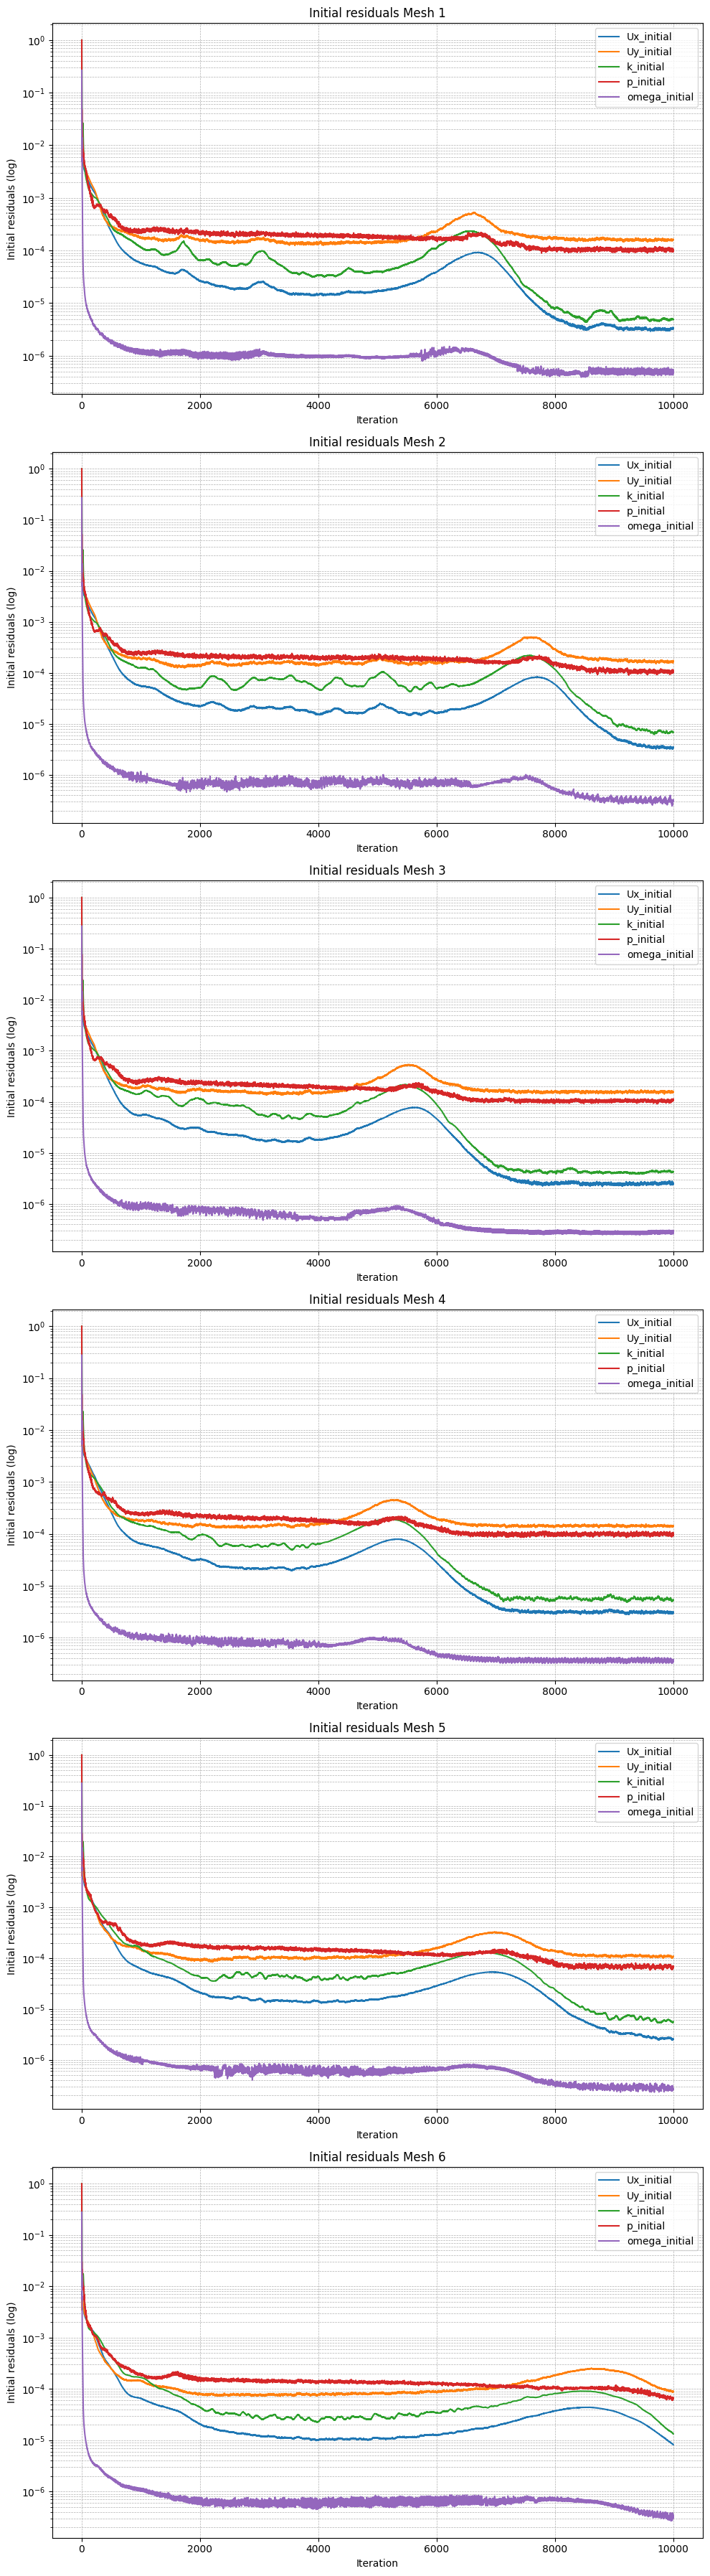

In [117]:
pltAllResiduals()

#### plot of the comparison of the residuals of each mesh

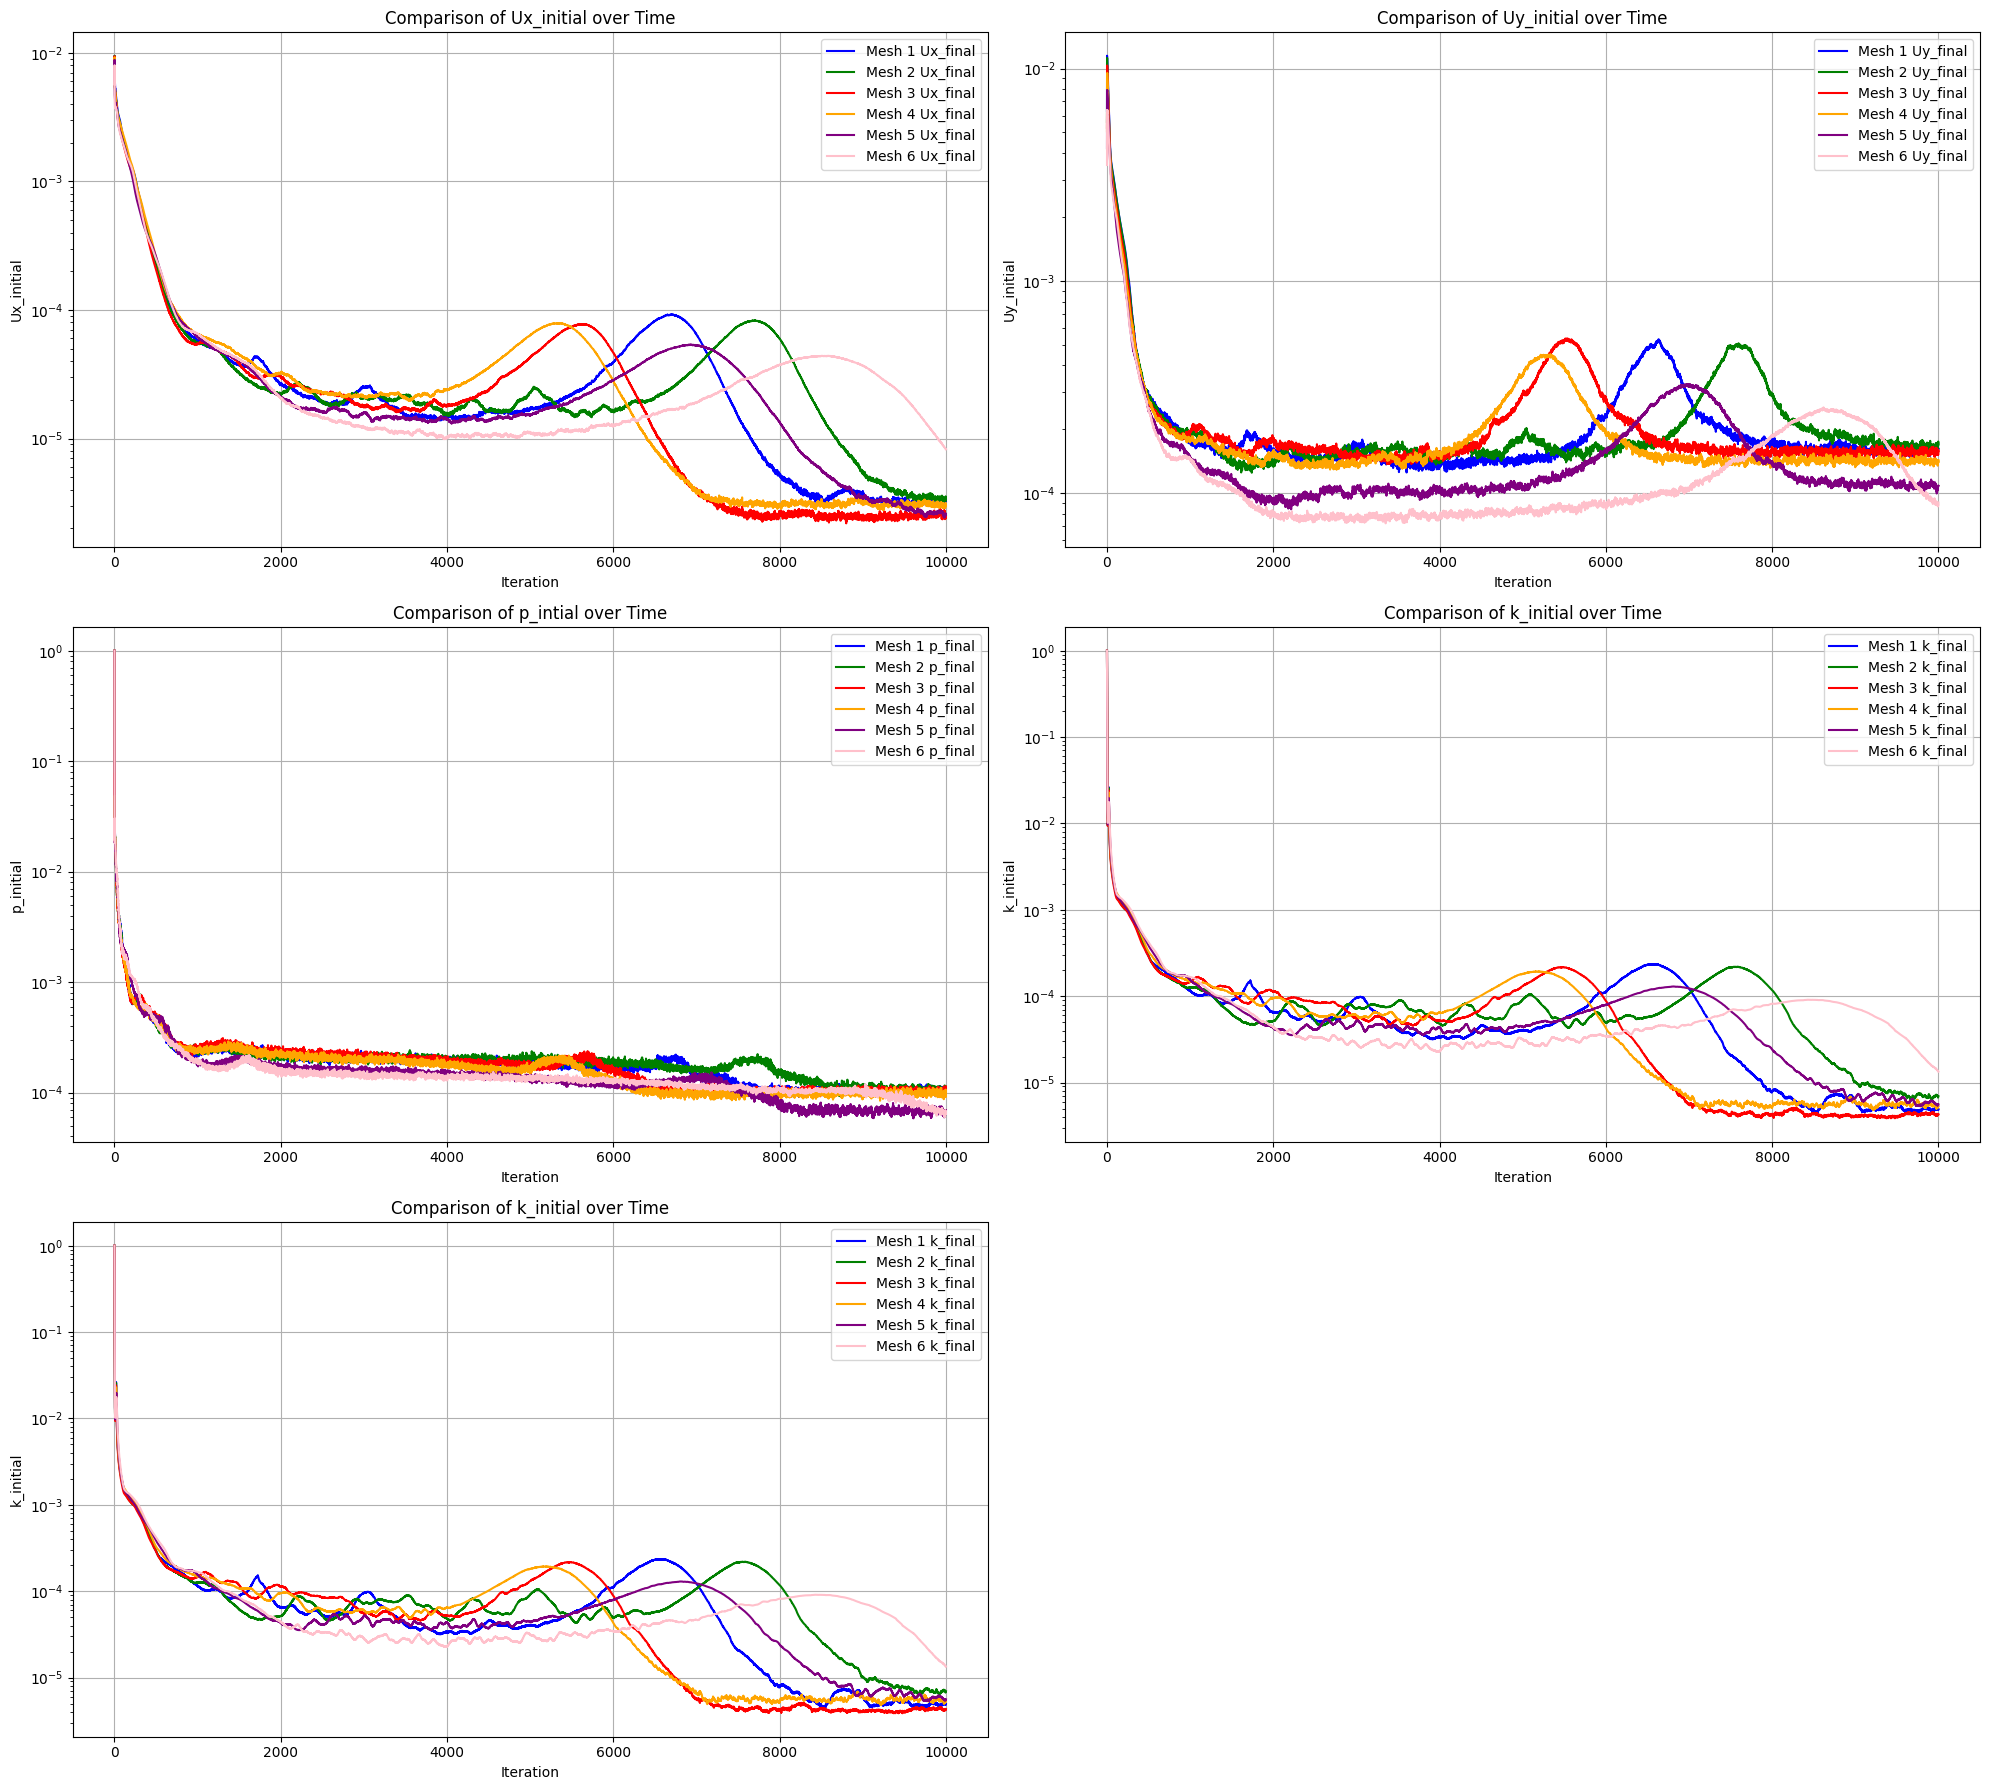

In [118]:
CompResiduals()

#### Plot of the wall shear stress of at the lower wall in the area of the ramp 

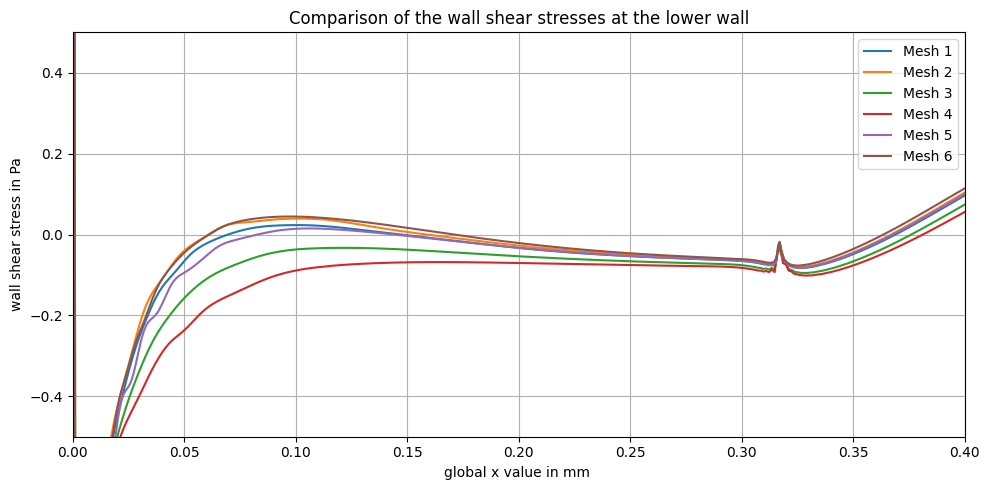

In [119]:
plot_wss()

#### Table of the wall shear stress at certain points in the global COS

In [120]:
# x values in the global COS for which the wall shear stress is desired 
x_targets = np.array([0.082, 0.122, 0.162, 0.202, 0.242, 0.282, 0.386])
mesh_range = range(1, num_meshes+1)  # Mesh 1 bis 5

# interpolation and genration of table 
interpolation_table = interpolate_wss_at_points(mesh_range, x_targets)
print(interpolation_table.to_string(index=False))

    x    Mesh 1    Mesh 2    Mesh 3    Mesh 4    Mesh 5    Mesh 6
0.082  0.017379  0.032448 -0.056401 -0.120765 -0.001118  0.039602
0.122  0.016035  0.030792 -0.032948 -0.074798  0.011211  0.036364
0.162 -0.009144 -0.002283 -0.041189 -0.068149 -0.010627  0.006980
0.202 -0.034292 -0.028518 -0.054445 -0.070638 -0.033711 -0.022382
0.242 -0.051197 -0.046564 -0.064588 -0.074902 -0.050693 -0.043259
0.282 -0.060757 -0.058162 -0.071389 -0.078177 -0.061016 -0.056025
0.386  0.051830  0.058608  0.030041  0.013732  0.055049  0.068878


#### Table of the wall shear stress at certain points in the ramp COS

In [121]:
# values of x in transformed from the global COS to the COS of the ramp
ramp_x = np.cos(np.radians(20))*x_targets

mesh_range = range(1, num_meshes+1)  # mesh 1 to 6

# Interpolation ausführen und anzeigen
interpolation_table2 = interpolate_wss_at_points(mesh_range, ramp_x)
print(interpolation_table2.to_string(index=False))

       x    Mesh 1    Mesh 2    Mesh 3    Mesh 4    Mesh 5    Mesh 6
0.077055  0.012012  0.030058 -0.065754 -0.133266 -0.007728  0.035316
0.114642  0.020073  0.036068 -0.033254 -0.078023  0.013746  0.040140
0.152230 -0.002824  0.004653 -0.038125 -0.068556 -0.004728  0.014783
0.189818 -0.027269 -0.021125 -0.050590 -0.069465 -0.027145 -0.014204
0.227406 -0.046106 -0.040973 -0.061294 -0.073369 -0.045333 -0.036685
0.264993 -0.057283 -0.053822 -0.068847 -0.076903 -0.057277 -0.051433
0.362721 -0.017248 -0.012012 -0.036726 -0.048867 -0.014200 -0.002432


#### Plot of the pressure along the upper wall

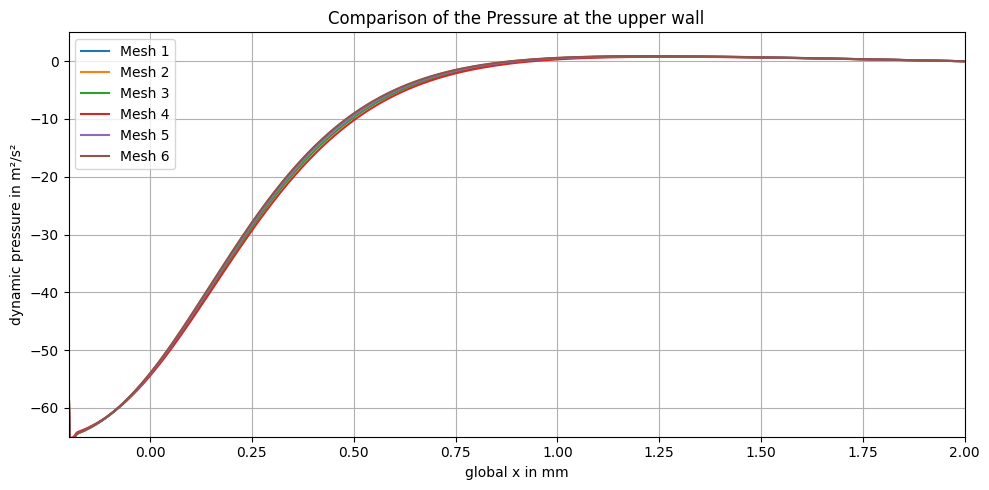

In [122]:
plot_p_upperWall()

#### plot of the wall shear stress along the upper wall

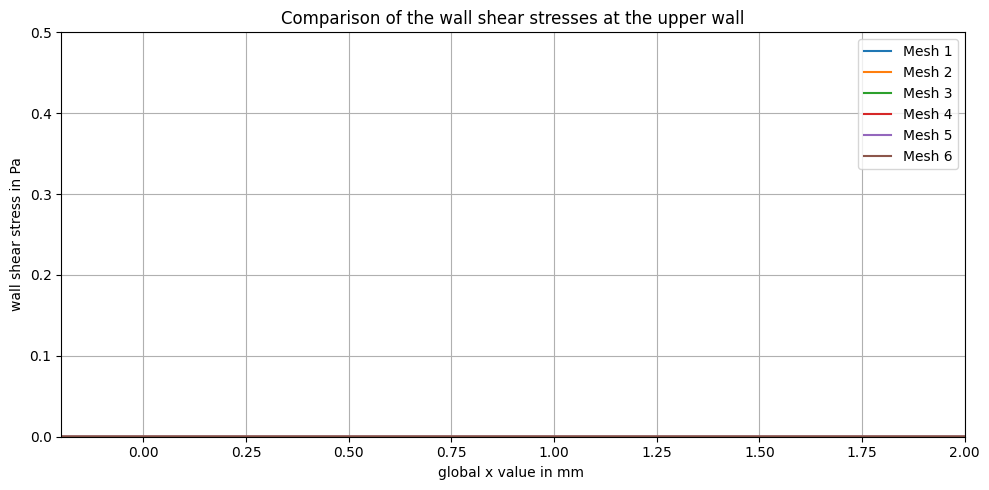

In [123]:
plot_wss_upperWall()